# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

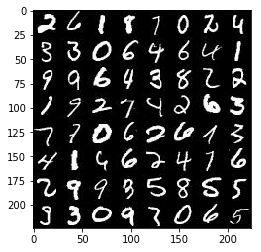

In [2]:
show_n_images = 64

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

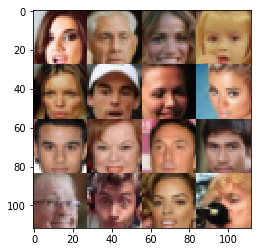

In [3]:
show_n_images = 16

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # create the placeholder for real_inputs. First dimension in tuple = 'None', which is confusing, but means
    # we can have ANY number of instances in the batch
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels),
                                name='inputs_real')
    
    # create the placeholder for the z inputs. These will be used by the generator to generate images
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="inputs_z")
    
    # create the learning rate.
    learn_rate = tf.placeholder(tf.float32, (None), name="learning_rate")
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    # set my alpha value for the leaky relu - using the same as the Udacity DCGAN walkthrough
    alpha = 0.2
    # reviewer comment - try using dropout in discriminator with low rate of dropping
    # reviewer comment - try using xavier initialisation. NOTE for the discriminator, the only one that
    # is a fully connected layer is the first one, so this is the only one to initialise.
    dropout_rate = 0.95
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input layer is 28*28*3 for the celebs, 28*28*1 for the MNIST
        
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        # don't apply the batch normalisation to the input layer
        relu1 = tf.maximum(alpha * x1, x1) # leaky relu
        # layer is now 14 * 14 * 64 (i.e. convoluted stack of 'images' of 14*14 across 64 filters)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        dropped2 = tf.nn.dropout(relu2, keep_prob=dropout_rate)
#         print('relu2.shape is {}'.format(relu2.shape))
        # layer is now 7 * 7 * 128
        
        x3 = tf.layers.conv2d(dropped2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        dropped3 = tf.nn.dropout(relu3, keep_prob=dropout_rate)
        print('relu3.shape is {}'.format(relu3.shape))
        # layer is now 4*4* 256 (or maybe 3*3? * 256)
        
        # Flatten this final tensor
        flat = tf.reshape(dropped3, (-1, 4*4*256)) # will find out here if my dimension calcs are correct
        print('flat.shape is {}'.format(flat.shape))
        logits = tf.layers.dense(flat, 1) # output to one because it is a simple yes/no as to whether it is a "True" pic
        out = tf.sigmoid(logits)
        
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Instructions for updating:
Use the retry module or similar alternatives.
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    # set my alpha level for the leaky relus - using the same as the Udacity DCGAN walk-through
    alpha = 0.2
    
    # reviewer comment - try using xavier intialisation for the weights. For the generator there are several
    # fully connected layers - use it for each?
    xavier_weights = tf.contrib.layers.xavier_initializer_conv2d()
    
    with tf.variable_scope("generator", reuse=not is_train):
        # this threw me for AGES - see Slack channel. You want to set reuse to True when is_training is False and
        # vice versa. When you are training you don't re-use the variables.
        
        # Reviewer suggestion - use 3 layers (previously had 2) - suggests 512, 256, 128 to output.
        
        # create first, fully connected layer
        x1_dense = tf.layers.dense(z, 7*7*512) # match the discriminator - work backwards
        
        # reshape it into a convolutional tensor and start the convolutional stack.
        x1 = tf.reshape(x1_dense, (-1, 7, 7, 512))
        bn1 = tf.layers.batch_normalization(x1, training= is_train)
        relu1 = tf.maximum(alpha * bn1, bn1) # leaky relu
        #print("relu1.shape is {}".format(relu1.shape))
        # layer is 7 * 7 * 512
        
        x2 = tf.layers.conv2d_transpose(relu1, 256, 5, strides=2, padding='same', kernel_initializer=xavier_weights)
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(alpha * bn2, bn2)
        #print("relu2.shape is {}".format(relu2.shape))
        # layer is now 14 * 14 * 256
        
        x3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='same', kernel_initializer=xavier_weights)
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(alpha * bn3, bn3)
#         print("relu3.shape is {}".format(relu3.shape))
        # layer is now 28 * 28  * 128
        
        # create the output layer
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=xavier_weights)
        # this is how we solve for the different RGB channel dimension diffs between the MNIST and celeba
        # as the number of 'filters' is now the number of channels. Same thing.
        # Note we need to set the strides at 1, as the image shape is already 28 * 28 and we don't want to increase
        # it to 56*56.
        # layer is now 28 * 28 * 3 or 28 * 28 * 1
        #print('logits has shape: {}'.format(logits.shape))
        
        out = tf.tanh(logits)
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_real, labels = tf.ones_like(d_model_real))
    )
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels = tf.zeros_like(d_model_fake))
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    # reviewer comment - to try to prevent the discriminator from being too strong, only the discriminator labels
    # (one-sided) are reduced from 1 to 0.9. This is known as label smoothing.
    smooth = 0.1
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * (1 - smooth))
    ) 
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tvars = tf.trainable_variables()
    
    d_vars = [var for var in tvars if var.name.startswith('discriminator')]
    #print(d_vars)
    g_vars = [var for var in tvars if var.name.startswith('generator')]
    #print(g_vars)
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt= tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt= tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
#     saver = tf.train.Saver()
    
    # create the inputs placeholders etc using the model_inputs function
    # see playground cell below to see how I found out the dimensions
    inputs_real, inputs_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    # create the losses using the model_loss function
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    
    # optimize those losses using the model_opt() function
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate=learning_rate, beta1=beta1)

    losses = []
    # note - I have the losses in a list, but I don't actually return them at the end. This is because I don't
    # want to mess around with the Udacity cells when the code is run to generate figures etc. It's for future
    # projects, to remind me to store the losses to create graphs of training loss vs epochs
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                
                # TODO: Train Model
                # from Slack channel - the batch_images have data in range -0.5 to +0.5, so double them to get the image
                batch_images = batch_images *2
                
                
                # create random noise z_inputs to seed the generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images,
                                                   inputs_z: batch_z,
                                                   learn_rate: learning_rate
                })
                _ = sess.run(g_opt, feed_dict={inputs_real: batch_images,
                                                    inputs_z: batch_z,
                                                    learn_rate: learning_rate
                    
                })
                
                # calculate loss every 25 batches?
                if steps % 25 == 0:
                    train_loss_d = d_loss.eval(feed_dict={
                        inputs_real: batch_images,
                        inputs_z: batch_z
                    })
                    train_loss_g = g_loss.eval(feed_dict={
                        inputs_z: batch_z
                    })
                    print('Epoch: {}'.format(epoch_i + 1), end=", ")
                    print('Batch: {}'.format(steps), end=": ")
                    print('Discr train loss: {:.3f}'.format(train_loss_d), end=", ")
                    print('Gen train loss: {:.3f}'.format(train_loss_g))
                    
                    # save losses to view after training:
                    losses.append((train_loss_d, train_loss_g))
                
                # show the images created every 100 batches?
                if steps % 100 == 0:
                    # as per instructions, run the show_generator_output every 100 batches
                    show_generator_output(sess, n_images=36, input_z=inputs_z, out_channel_dim=data_shape[3],
                                         image_mode=data_image_mode)
        #saver.save(sess, './checkpoints/generator.ckpt')
                

In [12]:
# DCFW created playground cell to find out attributes etc.
mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print (mnist_dataset.shape) # finding the dimensions - need this for the inputs

(60000, 28, 28, 1)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

following comments from reviewer, looked at [Radford paper](https://arxiv.org/abs/1511.06434) for hyperparameter suggestions.

relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Epoch: 1, Batch: 25: Discr train loss: 0.796, Gen train loss: 0.868
Epoch: 1, Batch: 50: Discr train loss: 1.747, Gen train loss: 0.490
Epoch: 1, Batch: 75: Discr train loss: 1.711, Gen train loss: 0.511
Epoch: 1, Batch: 100: Discr train loss: 1.998, Gen train loss: 0.365


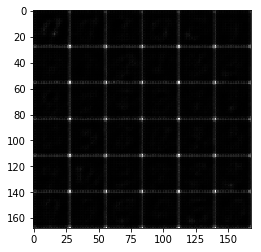

Epoch: 1, Batch: 125: Discr train loss: 1.495, Gen train loss: 0.908
Epoch: 1, Batch: 150: Discr train loss: 1.365, Gen train loss: 0.732
Epoch: 1, Batch: 175: Discr train loss: 1.560, Gen train loss: 0.451
Epoch: 1, Batch: 200: Discr train loss: 1.342, Gen train loss: 1.109


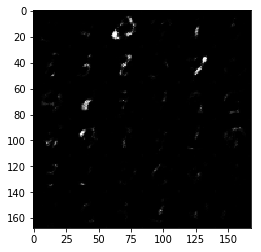

Epoch: 1, Batch: 225: Discr train loss: 1.320, Gen train loss: 0.499
Epoch: 1, Batch: 250: Discr train loss: 1.153, Gen train loss: 0.719
Epoch: 1, Batch: 275: Discr train loss: 1.358, Gen train loss: 0.918
Epoch: 1, Batch: 300: Discr train loss: 1.329, Gen train loss: 0.574


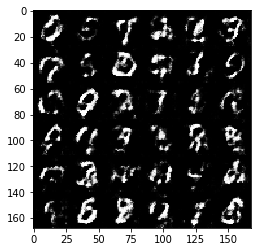

Epoch: 1, Batch: 325: Discr train loss: 1.132, Gen train loss: 1.105
Epoch: 1, Batch: 350: Discr train loss: 1.228, Gen train loss: 0.574
Epoch: 1, Batch: 375: Discr train loss: 1.243, Gen train loss: 1.270
Epoch: 1, Batch: 400: Discr train loss: 1.230, Gen train loss: 1.528


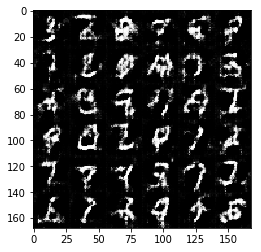

Epoch: 1, Batch: 425: Discr train loss: 1.263, Gen train loss: 0.647
Epoch: 1, Batch: 450: Discr train loss: 1.426, Gen train loss: 0.485
Epoch: 1, Batch: 475: Discr train loss: 1.157, Gen train loss: 0.825
Epoch: 1, Batch: 500: Discr train loss: 1.280, Gen train loss: 1.181


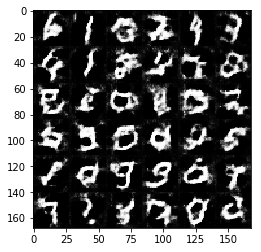

Epoch: 1, Batch: 525: Discr train loss: 1.290, Gen train loss: 0.616
Epoch: 1, Batch: 550: Discr train loss: 1.181, Gen train loss: 0.799
Epoch: 1, Batch: 575: Discr train loss: 1.094, Gen train loss: 0.702
Epoch: 1, Batch: 600: Discr train loss: 1.179, Gen train loss: 0.563


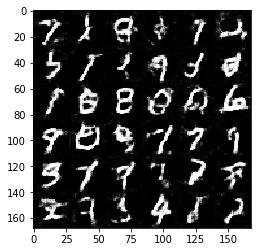

Epoch: 1, Batch: 625: Discr train loss: 1.516, Gen train loss: 0.537
Epoch: 1, Batch: 650: Discr train loss: 1.326, Gen train loss: 0.492
Epoch: 1, Batch: 675: Discr train loss: 1.443, Gen train loss: 0.523
Epoch: 1, Batch: 700: Discr train loss: 1.241, Gen train loss: 0.610


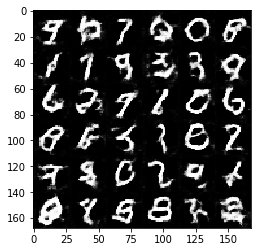

Epoch: 1, Batch: 725: Discr train loss: 1.302, Gen train loss: 0.545
Epoch: 1, Batch: 750: Discr train loss: 1.392, Gen train loss: 0.499
Epoch: 1, Batch: 775: Discr train loss: 1.247, Gen train loss: 0.576
Epoch: 1, Batch: 800: Discr train loss: 1.223, Gen train loss: 0.623


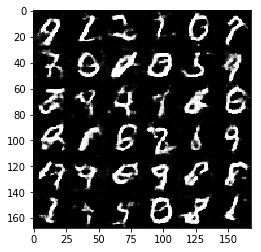

Epoch: 1, Batch: 825: Discr train loss: 0.962, Gen train loss: 1.080
Epoch: 1, Batch: 850: Discr train loss: 1.062, Gen train loss: 1.051
Epoch: 1, Batch: 875: Discr train loss: 1.235, Gen train loss: 0.698
Epoch: 1, Batch: 900: Discr train loss: 1.106, Gen train loss: 0.712


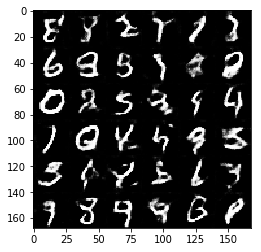

Epoch: 1, Batch: 925: Discr train loss: 0.987, Gen train loss: 0.831
Epoch: 1, Batch: 950: Discr train loss: 1.068, Gen train loss: 0.772
Epoch: 1, Batch: 975: Discr train loss: 1.078, Gen train loss: 0.842
Epoch: 1, Batch: 1000: Discr train loss: 1.102, Gen train loss: 0.898


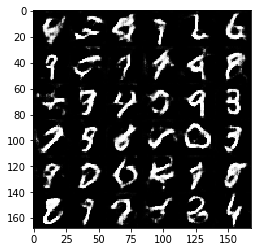

Epoch: 1, Batch: 1025: Discr train loss: 1.120, Gen train loss: 1.200
Epoch: 1, Batch: 1050: Discr train loss: 1.007, Gen train loss: 1.005
Epoch: 1, Batch: 1075: Discr train loss: 1.103, Gen train loss: 0.611
Epoch: 1, Batch: 1100: Discr train loss: 0.972, Gen train loss: 0.910


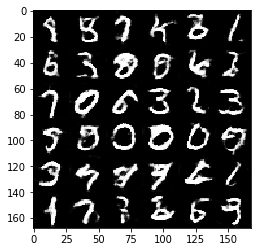

Epoch: 1, Batch: 1125: Discr train loss: 1.238, Gen train loss: 0.545
Epoch: 1, Batch: 1150: Discr train loss: 1.210, Gen train loss: 0.675
Epoch: 1, Batch: 1175: Discr train loss: 0.899, Gen train loss: 1.314
Epoch: 1, Batch: 1200: Discr train loss: 1.812, Gen train loss: 0.387


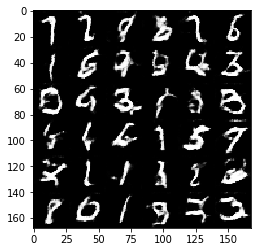

Epoch: 1, Batch: 1225: Discr train loss: 0.982, Gen train loss: 0.707
Epoch: 1, Batch: 1250: Discr train loss: 1.089, Gen train loss: 0.683
Epoch: 1, Batch: 1275: Discr train loss: 1.428, Gen train loss: 0.481
Epoch: 1, Batch: 1300: Discr train loss: 1.322, Gen train loss: 0.523


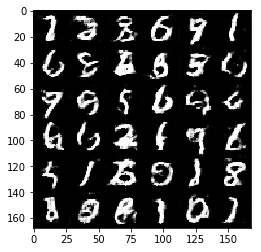

Epoch: 1, Batch: 1325: Discr train loss: 1.150, Gen train loss: 0.704
Epoch: 1, Batch: 1350: Discr train loss: 0.990, Gen train loss: 0.643
Epoch: 1, Batch: 1375: Discr train loss: 1.008, Gen train loss: 1.138
Epoch: 1, Batch: 1400: Discr train loss: 0.988, Gen train loss: 0.760


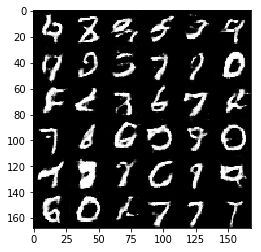

Epoch: 1, Batch: 1425: Discr train loss: 0.863, Gen train loss: 1.308
Epoch: 1, Batch: 1450: Discr train loss: 0.878, Gen train loss: 0.946
Epoch: 1, Batch: 1475: Discr train loss: 1.325, Gen train loss: 0.525
Epoch: 1, Batch: 1500: Discr train loss: 1.202, Gen train loss: 0.648


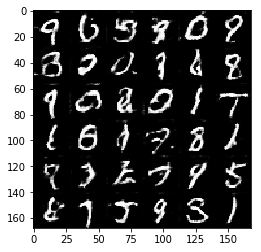

Epoch: 1, Batch: 1525: Discr train loss: 1.020, Gen train loss: 0.747
Epoch: 1, Batch: 1550: Discr train loss: 0.908, Gen train loss: 0.920
Epoch: 1, Batch: 1575: Discr train loss: 1.532, Gen train loss: 0.498
Epoch: 1, Batch: 1600: Discr train loss: 1.248, Gen train loss: 0.552


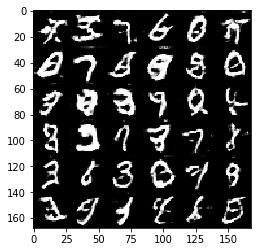

Epoch: 1, Batch: 1625: Discr train loss: 0.919, Gen train loss: 1.839
Epoch: 1, Batch: 1650: Discr train loss: 1.269, Gen train loss: 0.732
Epoch: 1, Batch: 1675: Discr train loss: 1.146, Gen train loss: 0.545
Epoch: 1, Batch: 1700: Discr train loss: 0.726, Gen train loss: 1.157


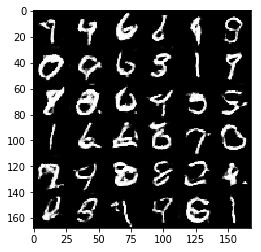

Epoch: 1, Batch: 1725: Discr train loss: 1.085, Gen train loss: 0.627
Epoch: 1, Batch: 1750: Discr train loss: 0.912, Gen train loss: 1.043
Epoch: 1, Batch: 1775: Discr train loss: 1.163, Gen train loss: 0.608
Epoch: 1, Batch: 1800: Discr train loss: 0.825, Gen train loss: 0.869


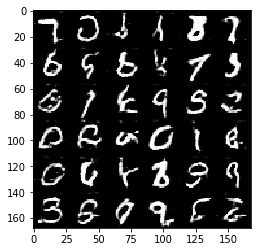

Epoch: 1, Batch: 1825: Discr train loss: 1.612, Gen train loss: 1.619
Epoch: 1, Batch: 1850: Discr train loss: 0.991, Gen train loss: 0.694
Epoch: 1, Batch: 1875: Discr train loss: 1.025, Gen train loss: 0.740
Epoch: 2, Batch: 1900: Discr train loss: 0.584, Gen train loss: 1.149


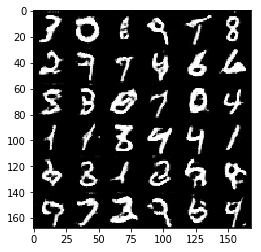

Epoch: 2, Batch: 1925: Discr train loss: 1.211, Gen train loss: 0.622
Epoch: 2, Batch: 1950: Discr train loss: 0.756, Gen train loss: 0.815
Epoch: 2, Batch: 1975: Discr train loss: 0.609, Gen train loss: 1.246
Epoch: 2, Batch: 2000: Discr train loss: 0.965, Gen train loss: 0.969


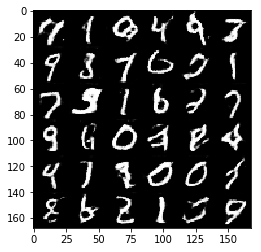

Epoch: 2, Batch: 2025: Discr train loss: 1.285, Gen train loss: 0.597
Epoch: 2, Batch: 2050: Discr train loss: 0.937, Gen train loss: 0.796
Epoch: 2, Batch: 2075: Discr train loss: 0.853, Gen train loss: 1.093
Epoch: 2, Batch: 2100: Discr train loss: 0.772, Gen train loss: 0.995


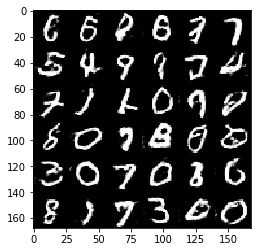

Epoch: 2, Batch: 2125: Discr train loss: 0.776, Gen train loss: 0.899
Epoch: 2, Batch: 2150: Discr train loss: 1.149, Gen train loss: 0.593
Epoch: 2, Batch: 2175: Discr train loss: 1.356, Gen train loss: 0.599
Epoch: 2, Batch: 2200: Discr train loss: 0.722, Gen train loss: 1.409


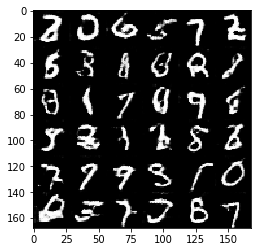

Epoch: 2, Batch: 2225: Discr train loss: 0.769, Gen train loss: 1.300
Epoch: 2, Batch: 2250: Discr train loss: 0.692, Gen train loss: 0.998
Epoch: 2, Batch: 2275: Discr train loss: 0.924, Gen train loss: 0.782
Epoch: 2, Batch: 2300: Discr train loss: 0.640, Gen train loss: 1.116


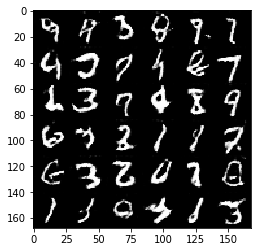

Epoch: 2, Batch: 2325: Discr train loss: 0.890, Gen train loss: 0.859
Epoch: 2, Batch: 2350: Discr train loss: 0.758, Gen train loss: 0.947
Epoch: 2, Batch: 2375: Discr train loss: 0.850, Gen train loss: 0.764
Epoch: 2, Batch: 2400: Discr train loss: 0.869, Gen train loss: 0.791


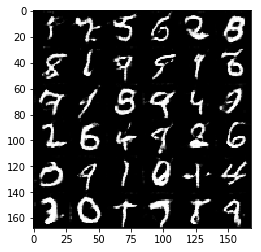

Epoch: 2, Batch: 2425: Discr train loss: 0.891, Gen train loss: 1.388
Epoch: 2, Batch: 2450: Discr train loss: 0.648, Gen train loss: 1.214
Epoch: 2, Batch: 2475: Discr train loss: 1.025, Gen train loss: 0.771
Epoch: 2, Batch: 2500: Discr train loss: 1.357, Gen train loss: 0.538


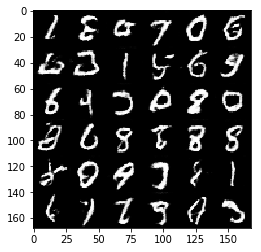

Epoch: 2, Batch: 2525: Discr train loss: 0.544, Gen train loss: 1.097
Epoch: 2, Batch: 2550: Discr train loss: 0.726, Gen train loss: 0.911
Epoch: 2, Batch: 2575: Discr train loss: 1.200, Gen train loss: 0.597
Epoch: 2, Batch: 2600: Discr train loss: 0.522, Gen train loss: 3.024


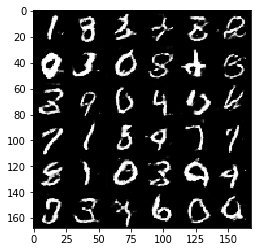

Epoch: 2, Batch: 2625: Discr train loss: 0.770, Gen train loss: 1.348
Epoch: 2, Batch: 2650: Discr train loss: 0.785, Gen train loss: 0.998
Epoch: 2, Batch: 2675: Discr train loss: 0.469, Gen train loss: 2.331
Epoch: 2, Batch: 2700: Discr train loss: 0.762, Gen train loss: 0.905


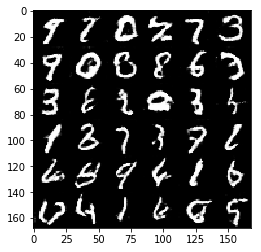

Epoch: 2, Batch: 2725: Discr train loss: 0.591, Gen train loss: 1.156
Epoch: 2, Batch: 2750: Discr train loss: 0.203, Gen train loss: 2.437
Epoch: 2, Batch: 2775: Discr train loss: 0.954, Gen train loss: 1.811
Epoch: 2, Batch: 2800: Discr train loss: 0.574, Gen train loss: 1.245


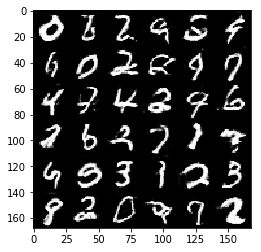

Epoch: 2, Batch: 2825: Discr train loss: 0.776, Gen train loss: 1.231
Epoch: 2, Batch: 2850: Discr train loss: 0.846, Gen train loss: 0.930
Epoch: 2, Batch: 2875: Discr train loss: 0.722, Gen train loss: 0.871
Epoch: 2, Batch: 2900: Discr train loss: 0.747, Gen train loss: 0.991


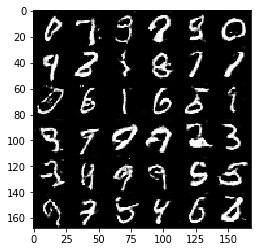

Epoch: 2, Batch: 2925: Discr train loss: 0.496, Gen train loss: 1.213
Epoch: 2, Batch: 2950: Discr train loss: 0.798, Gen train loss: 0.808
Epoch: 2, Batch: 2975: Discr train loss: 0.476, Gen train loss: 1.254
Epoch: 2, Batch: 3000: Discr train loss: 0.924, Gen train loss: 0.713


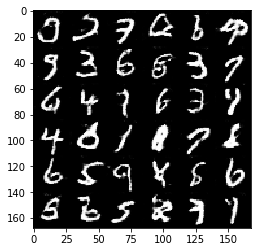

Epoch: 2, Batch: 3025: Discr train loss: 0.584, Gen train loss: 1.027
Epoch: 2, Batch: 3050: Discr train loss: 0.717, Gen train loss: 0.936
Epoch: 2, Batch: 3075: Discr train loss: 0.749, Gen train loss: 0.953
Epoch: 2, Batch: 3100: Discr train loss: 0.681, Gen train loss: 0.951


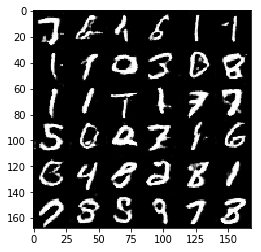

Epoch: 2, Batch: 3125: Discr train loss: 0.773, Gen train loss: 0.875
Epoch: 2, Batch: 3150: Discr train loss: 0.909, Gen train loss: 0.946
Epoch: 2, Batch: 3175: Discr train loss: 0.336, Gen train loss: 1.755
Epoch: 2, Batch: 3200: Discr train loss: 0.659, Gen train loss: 1.018


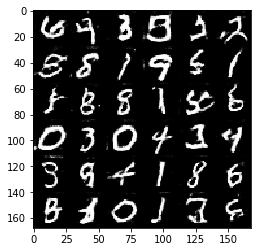

Epoch: 2, Batch: 3225: Discr train loss: 0.771, Gen train loss: 1.039
Epoch: 2, Batch: 3250: Discr train loss: 0.690, Gen train loss: 1.001
Epoch: 2, Batch: 3275: Discr train loss: 0.836, Gen train loss: 0.957
Epoch: 2, Batch: 3300: Discr train loss: 2.225, Gen train loss: 3.466


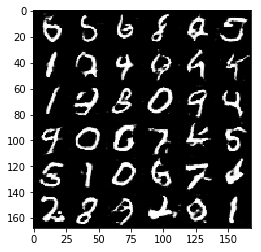

Epoch: 2, Batch: 3325: Discr train loss: 0.771, Gen train loss: 1.523
Epoch: 2, Batch: 3350: Discr train loss: 1.139, Gen train loss: 0.725
Epoch: 2, Batch: 3375: Discr train loss: 0.837, Gen train loss: 0.820
Epoch: 2, Batch: 3400: Discr train loss: 0.415, Gen train loss: 1.416


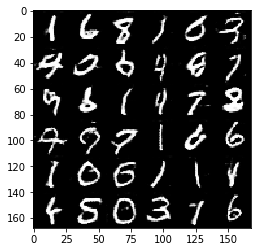

Epoch: 2, Batch: 3425: Discr train loss: 0.917, Gen train loss: 0.739
Epoch: 2, Batch: 3450: Discr train loss: 0.922, Gen train loss: 0.754
Epoch: 2, Batch: 3475: Discr train loss: 1.214, Gen train loss: 0.599
Epoch: 2, Batch: 3500: Discr train loss: 0.710, Gen train loss: 1.050


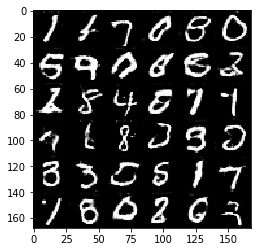

Epoch: 2, Batch: 3525: Discr train loss: 1.549, Gen train loss: 0.500
Epoch: 2, Batch: 3550: Discr train loss: 1.164, Gen train loss: 0.604
Epoch: 2, Batch: 3575: Discr train loss: 0.433, Gen train loss: 1.921
Epoch: 2, Batch: 3600: Discr train loss: 0.880, Gen train loss: 0.778


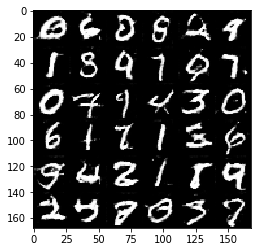

Epoch: 2, Batch: 3625: Discr train loss: 2.340, Gen train loss: 3.732
Epoch: 2, Batch: 3650: Discr train loss: 0.698, Gen train loss: 0.920
Epoch: 2, Batch: 3675: Discr train loss: 1.100, Gen train loss: 0.777
Epoch: 2, Batch: 3700: Discr train loss: 0.640, Gen train loss: 1.072


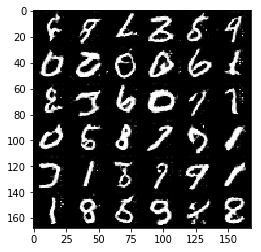

Epoch: 2, Batch: 3725: Discr train loss: 0.798, Gen train loss: 1.044
Epoch: 2, Batch: 3750: Discr train loss: 0.669, Gen train loss: 1.192


In [13]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
relu3.shape is (?, 4, 4, 256)
flat.shape is (?, 4096)
Epoch: 1, Batch: 25: Discr train loss: 0.401, Gen train loss: 2.664
Epoch: 1, Batch: 50: Discr train loss: 1.842, Gen train loss: 0.415
Epoch: 1, Batch: 75: Discr train loss: 0.429, Gen train loss: 1.765
Epoch: 1, Batch: 100: Discr train loss: 1.656, Gen train loss: 0.456


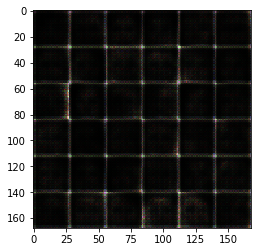

Epoch: 1, Batch: 125: Discr train loss: 1.742, Gen train loss: 0.392
Epoch: 1, Batch: 150: Discr train loss: 0.500, Gen train loss: 1.413
Epoch: 1, Batch: 175: Discr train loss: 0.892, Gen train loss: 3.556
Epoch: 1, Batch: 200: Discr train loss: 1.986, Gen train loss: 1.128


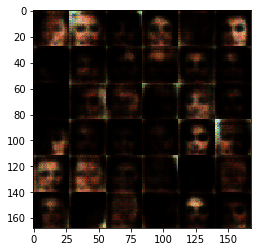

Epoch: 1, Batch: 225: Discr train loss: 0.883, Gen train loss: 0.738
Epoch: 1, Batch: 250: Discr train loss: 1.270, Gen train loss: 0.649
Epoch: 1, Batch: 275: Discr train loss: 0.772, Gen train loss: 3.602
Epoch: 1, Batch: 300: Discr train loss: 0.703, Gen train loss: 3.310


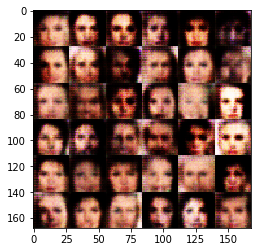

Epoch: 1, Batch: 325: Discr train loss: 0.321, Gen train loss: 2.966
Epoch: 1, Batch: 350: Discr train loss: 0.416, Gen train loss: 1.984
Epoch: 1, Batch: 375: Discr train loss: 0.470, Gen train loss: 1.811
Epoch: 1, Batch: 400: Discr train loss: 0.632, Gen train loss: 0.902


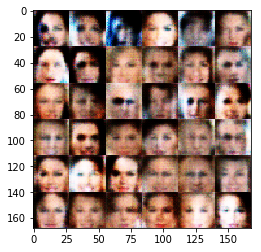

Epoch: 1, Batch: 425: Discr train loss: 1.788, Gen train loss: 0.385
Epoch: 1, Batch: 450: Discr train loss: 1.475, Gen train loss: 0.456
Epoch: 1, Batch: 475: Discr train loss: 1.702, Gen train loss: 0.425
Epoch: 1, Batch: 500: Discr train loss: 0.922, Gen train loss: 0.770


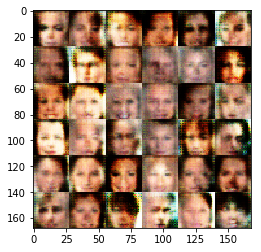

Epoch: 1, Batch: 525: Discr train loss: 1.290, Gen train loss: 0.529
Epoch: 1, Batch: 550: Discr train loss: 0.525, Gen train loss: 4.080
Epoch: 1, Batch: 575: Discr train loss: 0.324, Gen train loss: 2.569
Epoch: 1, Batch: 600: Discr train loss: 0.379, Gen train loss: 2.171


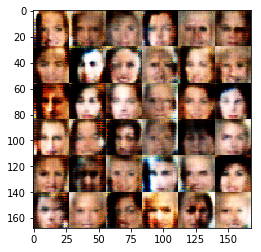

Epoch: 1, Batch: 625: Discr train loss: 2.358, Gen train loss: 2.557
Epoch: 1, Batch: 650: Discr train loss: 1.539, Gen train loss: 1.013
Epoch: 1, Batch: 675: Discr train loss: 0.435, Gen train loss: 1.732
Epoch: 1, Batch: 700: Discr train loss: 0.715, Gen train loss: 1.739


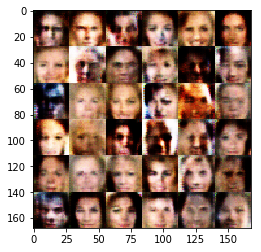

Epoch: 1, Batch: 725: Discr train loss: 2.498, Gen train loss: 1.446
Epoch: 1, Batch: 750: Discr train loss: 1.450, Gen train loss: 0.449
Epoch: 1, Batch: 775: Discr train loss: 0.633, Gen train loss: 1.158
Epoch: 1, Batch: 800: Discr train loss: 1.115, Gen train loss: 0.643


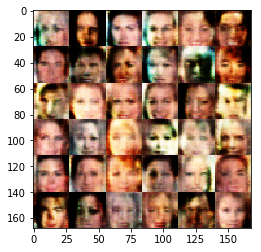

Epoch: 1, Batch: 825: Discr train loss: 1.454, Gen train loss: 0.434
Epoch: 1, Batch: 850: Discr train loss: 0.596, Gen train loss: 1.078
Epoch: 1, Batch: 875: Discr train loss: 1.375, Gen train loss: 0.894
Epoch: 1, Batch: 900: Discr train loss: 1.123, Gen train loss: 0.730


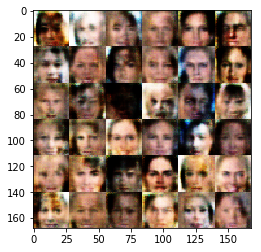

Epoch: 1, Batch: 925: Discr train loss: 1.451, Gen train loss: 2.367
Epoch: 1, Batch: 950: Discr train loss: 0.092, Gen train loss: 3.194
Epoch: 1, Batch: 975: Discr train loss: 1.574, Gen train loss: 0.454
Epoch: 1, Batch: 1000: Discr train loss: 1.864, Gen train loss: 4.176


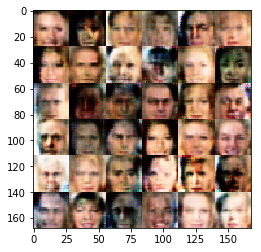

Epoch: 1, Batch: 1025: Discr train loss: 1.018, Gen train loss: 0.730
Epoch: 1, Batch: 1050: Discr train loss: 0.203, Gen train loss: 2.546
Epoch: 1, Batch: 1075: Discr train loss: 0.340, Gen train loss: 1.437
Epoch: 1, Batch: 1100: Discr train loss: 1.021, Gen train loss: 0.704


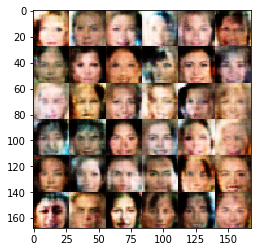

Epoch: 1, Batch: 1125: Discr train loss: 0.241, Gen train loss: 3.134
Epoch: 1, Batch: 1150: Discr train loss: 0.878, Gen train loss: 0.926
Epoch: 1, Batch: 1175: Discr train loss: 1.354, Gen train loss: 0.561
Epoch: 1, Batch: 1200: Discr train loss: 1.007, Gen train loss: 0.670


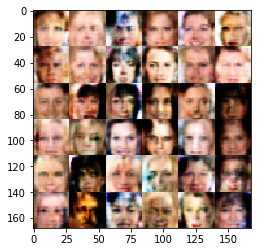

Epoch: 1, Batch: 1225: Discr train loss: 0.627, Gen train loss: 1.053
Epoch: 1, Batch: 1250: Discr train loss: 0.730, Gen train loss: 1.972
Epoch: 1, Batch: 1275: Discr train loss: 1.245, Gen train loss: 0.747
Epoch: 1, Batch: 1300: Discr train loss: 0.662, Gen train loss: 1.859


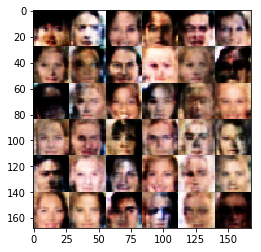

Epoch: 1, Batch: 1325: Discr train loss: 2.084, Gen train loss: 2.353
Epoch: 1, Batch: 1350: Discr train loss: 0.419, Gen train loss: 1.427
Epoch: 1, Batch: 1375: Discr train loss: 1.094, Gen train loss: 0.555
Epoch: 1, Batch: 1400: Discr train loss: 0.143, Gen train loss: 2.923


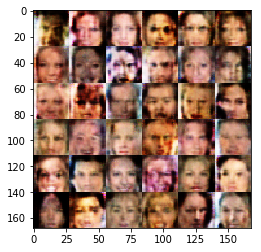

Epoch: 1, Batch: 1425: Discr train loss: 0.409, Gen train loss: 2.715
Epoch: 1, Batch: 1450: Discr train loss: 0.350, Gen train loss: 1.439
Epoch: 1, Batch: 1475: Discr train loss: 1.307, Gen train loss: 0.487
Epoch: 1, Batch: 1500: Discr train loss: 0.817, Gen train loss: 2.545


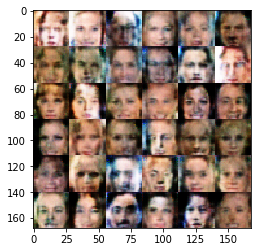

Epoch: 1, Batch: 1525: Discr train loss: 0.619, Gen train loss: 0.945
Epoch: 1, Batch: 1550: Discr train loss: 0.826, Gen train loss: 1.502
Epoch: 1, Batch: 1575: Discr train loss: 0.963, Gen train loss: 0.784
Epoch: 1, Batch: 1600: Discr train loss: 1.236, Gen train loss: 0.618


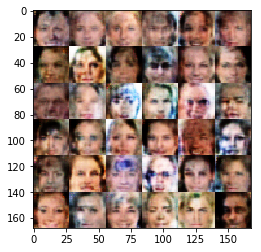

Epoch: 1, Batch: 1625: Discr train loss: 0.778, Gen train loss: 0.895
Epoch: 1, Batch: 1650: Discr train loss: 0.200, Gen train loss: 2.851
Epoch: 1, Batch: 1675: Discr train loss: 0.968, Gen train loss: 0.752
Epoch: 1, Batch: 1700: Discr train loss: 0.340, Gen train loss: 4.823


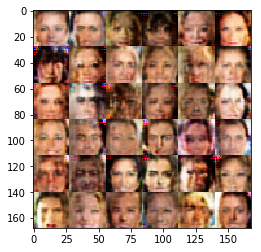

Epoch: 1, Batch: 1725: Discr train loss: 0.873, Gen train loss: 2.141
Epoch: 1, Batch: 1750: Discr train loss: 0.466, Gen train loss: 1.349
Epoch: 1, Batch: 1775: Discr train loss: 0.811, Gen train loss: 0.847
Epoch: 1, Batch: 1800: Discr train loss: 0.523, Gen train loss: 1.130


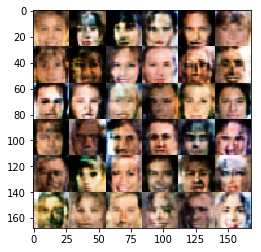

Epoch: 1, Batch: 1825: Discr train loss: 0.331, Gen train loss: 2.166
Epoch: 1, Batch: 1850: Discr train loss: 1.415, Gen train loss: 1.209
Epoch: 1, Batch: 1875: Discr train loss: 0.942, Gen train loss: 1.942
Epoch: 1, Batch: 1900: Discr train loss: 1.310, Gen train loss: 0.535


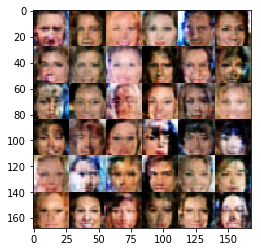

Epoch: 1, Batch: 1925: Discr train loss: 1.801, Gen train loss: 2.353
Epoch: 1, Batch: 1950: Discr train loss: 1.212, Gen train loss: 0.632
Epoch: 1, Batch: 1975: Discr train loss: 1.008, Gen train loss: 0.961
Epoch: 1, Batch: 2000: Discr train loss: 0.587, Gen train loss: 1.418


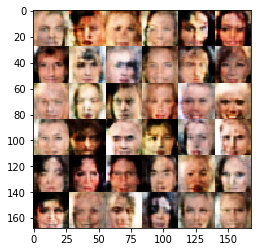

Epoch: 1, Batch: 2025: Discr train loss: 0.240, Gen train loss: 2.482
Epoch: 1, Batch: 2050: Discr train loss: 0.520, Gen train loss: 1.128
Epoch: 1, Batch: 2075: Discr train loss: 1.139, Gen train loss: 1.881
Epoch: 1, Batch: 2100: Discr train loss: 0.152, Gen train loss: 2.801


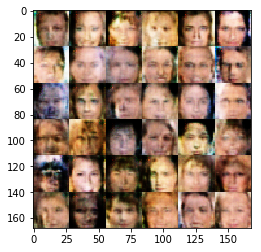

Epoch: 1, Batch: 2125: Discr train loss: 1.144, Gen train loss: 0.725
Epoch: 1, Batch: 2150: Discr train loss: 0.275, Gen train loss: 1.942
Epoch: 1, Batch: 2175: Discr train loss: 0.636, Gen train loss: 0.899
Epoch: 1, Batch: 2200: Discr train loss: 0.291, Gen train loss: 3.061


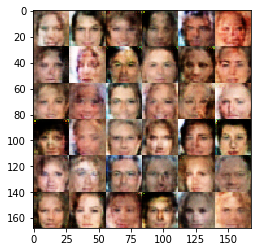

Epoch: 1, Batch: 2225: Discr train loss: 0.289, Gen train loss: 2.951
Epoch: 1, Batch: 2250: Discr train loss: 0.203, Gen train loss: 2.121
Epoch: 1, Batch: 2275: Discr train loss: 1.064, Gen train loss: 1.062
Epoch: 1, Batch: 2300: Discr train loss: 1.725, Gen train loss: 0.412


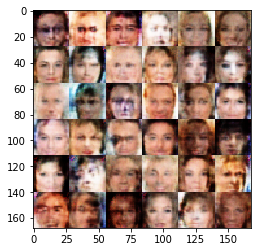

Epoch: 1, Batch: 2325: Discr train loss: 0.669, Gen train loss: 0.863
Epoch: 1, Batch: 2350: Discr train loss: 0.432, Gen train loss: 1.271
Epoch: 1, Batch: 2375: Discr train loss: 1.408, Gen train loss: 1.584
Epoch: 1, Batch: 2400: Discr train loss: 0.949, Gen train loss: 0.608


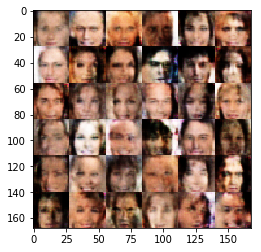

Epoch: 1, Batch: 2425: Discr train loss: 1.322, Gen train loss: 1.344
Epoch: 1, Batch: 2450: Discr train loss: 1.367, Gen train loss: 0.489
Epoch: 1, Batch: 2475: Discr train loss: 0.899, Gen train loss: 0.807
Epoch: 1, Batch: 2500: Discr train loss: 1.129, Gen train loss: 0.652


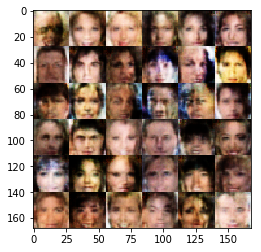

Epoch: 1, Batch: 2525: Discr train loss: 0.264, Gen train loss: 2.662
Epoch: 1, Batch: 2550: Discr train loss: 0.492, Gen train loss: 1.435
Epoch: 1, Batch: 2575: Discr train loss: 0.477, Gen train loss: 1.800
Epoch: 1, Batch: 2600: Discr train loss: 0.899, Gen train loss: 0.823


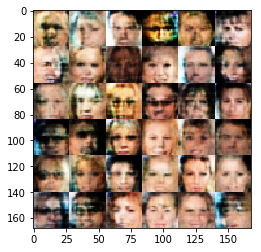

Epoch: 1, Batch: 2625: Discr train loss: 1.138, Gen train loss: 0.559
Epoch: 1, Batch: 2650: Discr train loss: 1.033, Gen train loss: 2.001
Epoch: 1, Batch: 2675: Discr train loss: 0.425, Gen train loss: 2.325
Epoch: 1, Batch: 2700: Discr train loss: 0.317, Gen train loss: 2.242


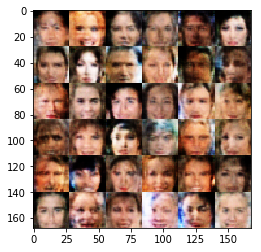

Epoch: 1, Batch: 2725: Discr train loss: 0.992, Gen train loss: 0.950
Epoch: 1, Batch: 2750: Discr train loss: 0.513, Gen train loss: 1.355
Epoch: 1, Batch: 2775: Discr train loss: 0.609, Gen train loss: 1.277
Epoch: 1, Batch: 2800: Discr train loss: 0.573, Gen train loss: 1.167


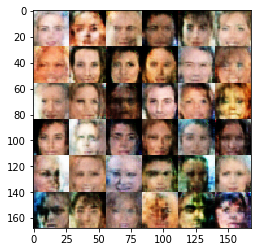

Epoch: 1, Batch: 2825: Discr train loss: 1.691, Gen train loss: 2.164
Epoch: 1, Batch: 2850: Discr train loss: 0.362, Gen train loss: 1.294
Epoch: 1, Batch: 2875: Discr train loss: 0.268, Gen train loss: 2.486
Epoch: 1, Batch: 2900: Discr train loss: 1.270, Gen train loss: 0.636


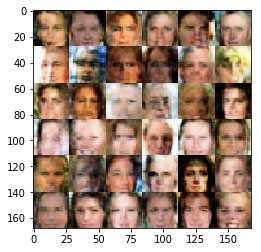

Epoch: 1, Batch: 2925: Discr train loss: 1.128, Gen train loss: 0.681
Epoch: 1, Batch: 2950: Discr train loss: 1.055, Gen train loss: 2.770
Epoch: 1, Batch: 2975: Discr train loss: 1.219, Gen train loss: 0.516
Epoch: 1, Batch: 3000: Discr train loss: 0.456, Gen train loss: 2.621


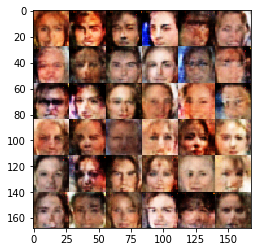

Epoch: 1, Batch: 3025: Discr train loss: 1.224, Gen train loss: 1.763
Epoch: 1, Batch: 3050: Discr train loss: 1.979, Gen train loss: 2.640
Epoch: 1, Batch: 3075: Discr train loss: 0.892, Gen train loss: 0.701
Epoch: 1, Batch: 3100: Discr train loss: 3.293, Gen train loss: 2.817


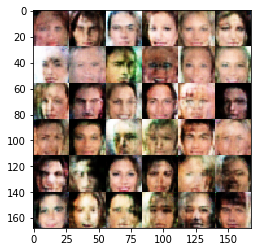

Epoch: 1, Batch: 3125: Discr train loss: 0.354, Gen train loss: 1.949
Epoch: 1, Batch: 3150: Discr train loss: 0.668, Gen train loss: 1.229
Epoch: 1, Batch: 3175: Discr train loss: 0.332, Gen train loss: 1.991
Epoch: 1, Batch: 3200: Discr train loss: 1.218, Gen train loss: 0.520


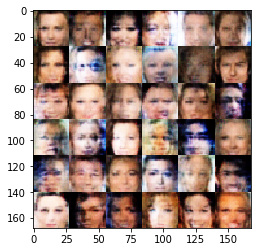

Epoch: 1, Batch: 3225: Discr train loss: 1.073, Gen train loss: 0.825
Epoch: 1, Batch: 3250: Discr train loss: 0.416, Gen train loss: 1.184
Epoch: 1, Batch: 3275: Discr train loss: 1.354, Gen train loss: 0.517
Epoch: 1, Batch: 3300: Discr train loss: 0.984, Gen train loss: 0.652


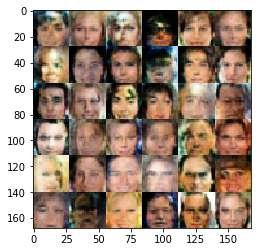

Epoch: 1, Batch: 3325: Discr train loss: 0.171, Gen train loss: 3.419
Epoch: 1, Batch: 3350: Discr train loss: 0.837, Gen train loss: 2.271
Epoch: 1, Batch: 3375: Discr train loss: 1.263, Gen train loss: 0.619
Epoch: 1, Batch: 3400: Discr train loss: 1.207, Gen train loss: 0.583


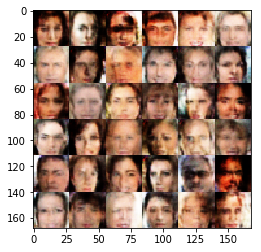

Epoch: 1, Batch: 3425: Discr train loss: 0.517, Gen train loss: 1.679
Epoch: 1, Batch: 3450: Discr train loss: 0.928, Gen train loss: 0.913
Epoch: 1, Batch: 3475: Discr train loss: 0.708, Gen train loss: 1.354
Epoch: 1, Batch: 3500: Discr train loss: 0.241, Gen train loss: 2.210


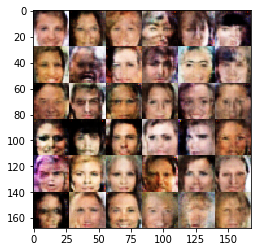

Epoch: 1, Batch: 3525: Discr train loss: 2.398, Gen train loss: 2.066
Epoch: 1, Batch: 3550: Discr train loss: 0.649, Gen train loss: 1.034
Epoch: 1, Batch: 3575: Discr train loss: 0.162, Gen train loss: 2.611
Epoch: 1, Batch: 3600: Discr train loss: 0.655, Gen train loss: 1.160


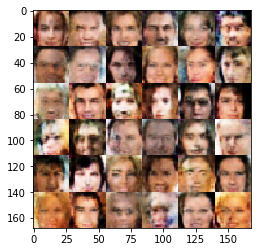

Epoch: 1, Batch: 3625: Discr train loss: 0.358, Gen train loss: 1.926
Epoch: 1, Batch: 3650: Discr train loss: 1.206, Gen train loss: 0.542
Epoch: 1, Batch: 3675: Discr train loss: 1.087, Gen train loss: 1.484
Epoch: 1, Batch: 3700: Discr train loss: 0.897, Gen train loss: 0.770


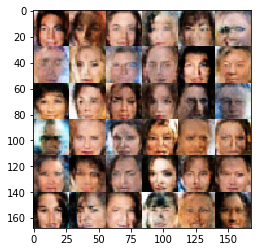

Epoch: 1, Batch: 3725: Discr train loss: 0.795, Gen train loss: 1.574
Epoch: 1, Batch: 3750: Discr train loss: 0.546, Gen train loss: 1.178
Epoch: 1, Batch: 3775: Discr train loss: 1.482, Gen train loss: 0.436
Epoch: 1, Batch: 3800: Discr train loss: 0.597, Gen train loss: 3.598


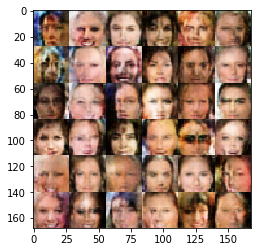

Epoch: 1, Batch: 3825: Discr train loss: 3.309, Gen train loss: 2.934
Epoch: 1, Batch: 3850: Discr train loss: 0.956, Gen train loss: 1.141
Epoch: 1, Batch: 3875: Discr train loss: 1.434, Gen train loss: 2.487
Epoch: 1, Batch: 3900: Discr train loss: 0.660, Gen train loss: 1.549


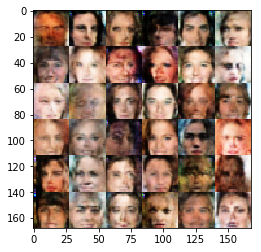

Epoch: 1, Batch: 3925: Discr train loss: 0.367, Gen train loss: 1.494
Epoch: 1, Batch: 3950: Discr train loss: 0.454, Gen train loss: 1.353
Epoch: 1, Batch: 3975: Discr train loss: 1.182, Gen train loss: 0.814
Epoch: 1, Batch: 4000: Discr train loss: 0.831, Gen train loss: 0.707


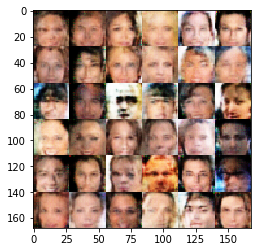

Epoch: 1, Batch: 4025: Discr train loss: 1.606, Gen train loss: 0.445
Epoch: 1, Batch: 4050: Discr train loss: 0.520, Gen train loss: 2.957
Epoch: 1, Batch: 4075: Discr train loss: 0.856, Gen train loss: 0.748
Epoch: 1, Batch: 4100: Discr train loss: 0.290, Gen train loss: 1.587


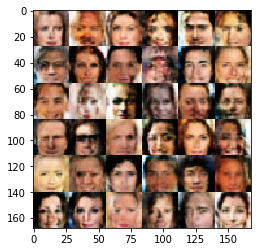

Epoch: 1, Batch: 4125: Discr train loss: 0.587, Gen train loss: 1.334
Epoch: 1, Batch: 4150: Discr train loss: 0.337, Gen train loss: 1.649
Epoch: 1, Batch: 4175: Discr train loss: 1.049, Gen train loss: 0.698
Epoch: 1, Batch: 4200: Discr train loss: 1.334, Gen train loss: 1.984


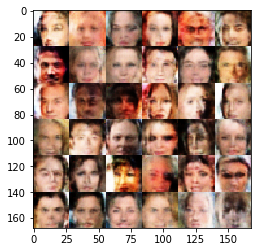

Epoch: 1, Batch: 4225: Discr train loss: 0.996, Gen train loss: 0.836
Epoch: 1, Batch: 4250: Discr train loss: 0.871, Gen train loss: 2.020
Epoch: 1, Batch: 4275: Discr train loss: 0.844, Gen train loss: 0.983
Epoch: 1, Batch: 4300: Discr train loss: 0.858, Gen train loss: 1.669


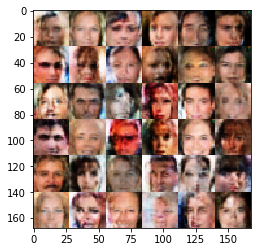

Epoch: 1, Batch: 4325: Discr train loss: 0.146, Gen train loss: 2.921
Epoch: 1, Batch: 4350: Discr train loss: 1.028, Gen train loss: 0.819
Epoch: 1, Batch: 4375: Discr train loss: 1.463, Gen train loss: 0.496
Epoch: 1, Batch: 4400: Discr train loss: 0.494, Gen train loss: 1.303


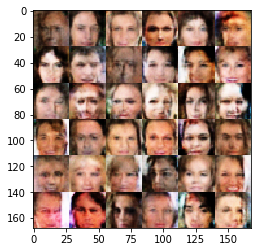

Epoch: 1, Batch: 4425: Discr train loss: 0.385, Gen train loss: 2.673
Epoch: 1, Batch: 4450: Discr train loss: 0.995, Gen train loss: 1.225
Epoch: 1, Batch: 4475: Discr train loss: 1.438, Gen train loss: 0.446
Epoch: 1, Batch: 4500: Discr train loss: 0.452, Gen train loss: 1.217


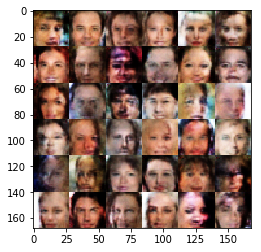

Epoch: 1, Batch: 4525: Discr train loss: 0.630, Gen train loss: 1.035
Epoch: 1, Batch: 4550: Discr train loss: 1.191, Gen train loss: 0.600
Epoch: 1, Batch: 4575: Discr train loss: 1.684, Gen train loss: 0.407
Epoch: 1, Batch: 4600: Discr train loss: 1.504, Gen train loss: 0.413


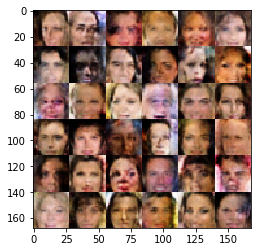

Epoch: 1, Batch: 4625: Discr train loss: 0.419, Gen train loss: 1.481
Epoch: 1, Batch: 4650: Discr train loss: 0.480, Gen train loss: 1.474
Epoch: 1, Batch: 4675: Discr train loss: 1.227, Gen train loss: 0.618
Epoch: 1, Batch: 4700: Discr train loss: 0.431, Gen train loss: 1.369


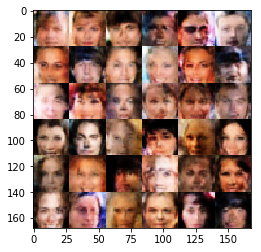

Epoch: 1, Batch: 4725: Discr train loss: 1.292, Gen train loss: 1.834
Epoch: 1, Batch: 4750: Discr train loss: 1.217, Gen train loss: 0.535
Epoch: 1, Batch: 4775: Discr train loss: 0.803, Gen train loss: 0.875
Epoch: 1, Batch: 4800: Discr train loss: 0.819, Gen train loss: 0.854


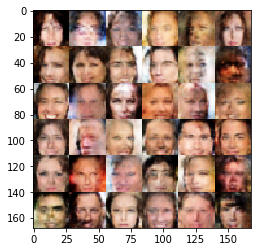

Epoch: 1, Batch: 4825: Discr train loss: 0.344, Gen train loss: 2.671
Epoch: 1, Batch: 4850: Discr train loss: 0.630, Gen train loss: 0.926
Epoch: 1, Batch: 4875: Discr train loss: 0.777, Gen train loss: 0.765
Epoch: 1, Batch: 4900: Discr train loss: 1.028, Gen train loss: 0.688


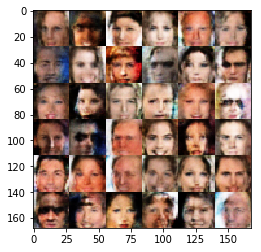

Epoch: 1, Batch: 4925: Discr train loss: 0.786, Gen train loss: 0.981
Epoch: 1, Batch: 4950: Discr train loss: 0.885, Gen train loss: 1.184
Epoch: 1, Batch: 4975: Discr train loss: 1.290, Gen train loss: 0.555
Epoch: 1, Batch: 5000: Discr train loss: 2.961, Gen train loss: 2.090


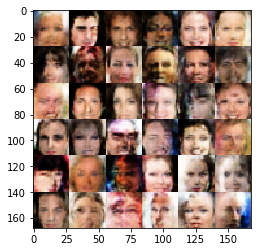

Epoch: 1, Batch: 5025: Discr train loss: 1.169, Gen train loss: 0.604
Epoch: 1, Batch: 5050: Discr train loss: 0.508, Gen train loss: 1.356
Epoch: 1, Batch: 5075: Discr train loss: 0.301, Gen train loss: 3.223
Epoch: 1, Batch: 5100: Discr train loss: 1.659, Gen train loss: 4.250


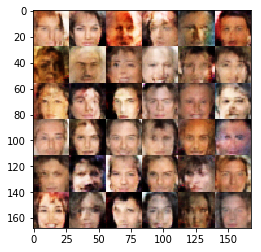

Epoch: 1, Batch: 5125: Discr train loss: 0.476, Gen train loss: 1.568
Epoch: 1, Batch: 5150: Discr train loss: 0.735, Gen train loss: 0.852
Epoch: 1, Batch: 5175: Discr train loss: 1.155, Gen train loss: 0.540
Epoch: 1, Batch: 5200: Discr train loss: 1.188, Gen train loss: 1.036


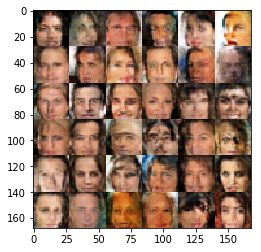

Epoch: 1, Batch: 5225: Discr train loss: 0.940, Gen train loss: 1.351
Epoch: 1, Batch: 5250: Discr train loss: 0.862, Gen train loss: 0.825
Epoch: 1, Batch: 5275: Discr train loss: 0.886, Gen train loss: 0.974
Epoch: 1, Batch: 5300: Discr train loss: 0.764, Gen train loss: 2.527


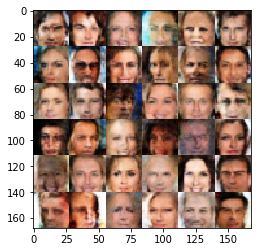

Epoch: 1, Batch: 5325: Discr train loss: 1.239, Gen train loss: 0.824
Epoch: 1, Batch: 5350: Discr train loss: 0.191, Gen train loss: 4.035
Epoch: 1, Batch: 5375: Discr train loss: 1.380, Gen train loss: 1.017
Epoch: 1, Batch: 5400: Discr train loss: 0.261, Gen train loss: 2.641


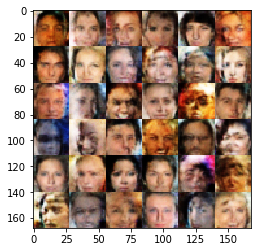

Epoch: 1, Batch: 5425: Discr train loss: 0.693, Gen train loss: 1.129
Epoch: 1, Batch: 5450: Discr train loss: 1.105, Gen train loss: 0.923


In [ ]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.